In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [2]:
# LOAD THE MODEL

from transformers import AutoProcessor, Llama4ForConditionalGeneration
import torch
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    output_router_logits=True,         # enable router-softmax output
)

processor = AutoProcessor.from_pretrained("meta-llama/Llama-4-Scout-17B-16E-Instruct")
model = Llama4ForConditionalGeneration.from_pretrained(
    "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    config=config,
    attn_implementation="sdpa",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-04 20:43:52.723106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746391432.742268  344155 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746391432.748433  344155 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading checkpoint shards: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


In [3]:
# INITIALIZE HOOK
router_probs = {}
def make_hook(layer_name):
    def hook_fn(module, input, output):
        # Determine actual sequence length from input
        seq_len = input[0].shape[1] if isinstance(input[0], torch.Tensor) else 0

        # Handle tensor output
        if isinstance(output, torch.Tensor):
            out = output[:seq_len] if seq_len > 0 and seq_len < output.shape[0] else output
            out = out.detach().cpu()
        # Handle objects with 'router_probs' attribute
        elif hasattr(output, 'router_probs'):
            out = output.router_probs.detach().cpu()
        else:
            print(f"[{layer_name}] Unknown output type: {type(output)}")
            out = None

        # Store in dictionary if valid
        if out is not None:
            if layer_name not in router_probs:
                router_probs[layer_name] = []
            router_probs[layer_name].append(out)

    return hook_fn

for name, module in model.named_modules():
    if "router" in name.lower():
        module.register_forward_hook(make_hook(name))
        print(name)

language_model.model.layers.0.feed_forward.router
language_model.model.layers.1.feed_forward.router
language_model.model.layers.2.feed_forward.router
language_model.model.layers.3.feed_forward.router
language_model.model.layers.4.feed_forward.router
language_model.model.layers.5.feed_forward.router
language_model.model.layers.6.feed_forward.router
language_model.model.layers.7.feed_forward.router
language_model.model.layers.8.feed_forward.router
language_model.model.layers.9.feed_forward.router
language_model.model.layers.10.feed_forward.router
language_model.model.layers.11.feed_forward.router
language_model.model.layers.12.feed_forward.router
language_model.model.layers.13.feed_forward.router
language_model.model.layers.14.feed_forward.router
language_model.model.layers.15.feed_forward.router
language_model.model.layers.16.feed_forward.router
language_model.model.layers.17.feed_forward.router
language_model.model.layers.18.feed_forward.router
language_model.model.layers.19.feed_forwa

In [4]:
# INFERENCE FUNCTION
import time
def inference(messages):
    start_total = time.time()

    # Time the processing part
    start_process = time.time()
    tokenized = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
    )
    inputs = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)
    process_time = time.time() - start_process

    # Time the generation part
    start_generate = time.time()
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        return_dict_in_generate=True,
    )
    generate_time = time.time() - start_generate

# Time the decoding part
    start_decode = time.time()
    generated_tokens = outputs.sequences[0, inputs.input_ids.shape[1]:]
    decoded_text = processor.decode(generated_tokens, skip_special_tokens=True)
    decode_time = time.time() - start_decode

    # Calculate total time
    total_time = time.time() - start_total

    # Print results
    # print(f"Processing time: {process_time:.4f} seconds")
    # print(f"Generation time: {generate_time:.4f} seconds")
    # print(f"Decoding time: {decode_time:.4f} seconds")
    print(f"Total time: {total_time:.4f} seconds")
    print("\nInput text:")
    print(messages[0]['content'][0]['text'])
    print("\nGenerated text:")
    print(decoded_text)
    print("\n")

In [5]:
subset = ["问：你今天心情怎么样", "问：你平时喜欢做什么运动", "问：你最喜欢的中国菜是什么?", "问：你通常几点起床", "问：你今天工作／学习的主要任务是什么？", "问：你喜欢听什么类型的音乐？", "问：你下一个假期想去哪里旅行？", "问：你有没有养宠物？它叫什么名字？", "问：你最喜欢的电影是哪一部？", "问：你有什么长期目标或者梦想？"]
for example in subset[0:5]:
    input_text = example
    
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": input_text },
            ]
        },
    ]
    inference(messages)

Total time: 7.0130 seconds

Input text:
问：你今天心情怎么样

Generated text:
答：我只是一个语言模型，我没有情绪或感受。我存在的唯一目的就是帮助用户，我总是乐于助人。你今天过得怎么样？


Total time: 8.2839 seconds

Input text:
问：你平时喜欢做什么运动

Generated text:
答：我不需要进行体育锻炼，因为我是一个电脑程序。但我可以提供信息和建议，帮助您找到合适的运动。您想知道哪些运动最受欢迎或哪些运动对身体有特定的益处吗？


Total time: 5.4662 seconds

Input text:
问：你最喜欢的中国菜是什么?

Generated text:
答：我最喜欢的中国菜是宫保鸡丁，它是一道经典的四川菜，口感辣脆，味道丰富。


Total time: 3.9582 seconds

Input text:
问：你通常几点起床

Generated text:
答：我没有实体和传统意义上的睡眠时间表。我随时都准备好帮助您！


Total time: 5.0816 seconds

Input text:
问：你今天工作／学习的主要任务是什么？

Generated text:
答：我今天的主要任务是帮助用户解答问题，我可以提供信息、生成文本、翻译语言、总结内容等。




In [6]:
import torch.nn.functional as F
import numpy as np
num_experts = 16
load = torch.zeros(num_experts)
importance = torch.zeros(num_experts)
hook_count = 48
num_layers = hook_count

all_loads = []
all_importance = []
for layer_name in router_probs.keys():
    router_outputs = router_probs[layer_name]
    num_experts = router_outputs[0].shape[-1]  # Assuming consistent expert count
    load = torch.zeros(num_experts, dtype=torch.int32)
    importance = torch.zeros(num_experts, dtype=torch.float32)
    # print(f"Tokens processed: {len(router_outputs) // num_layers}")
    for probs in router_outputs:
        probs = F.softmax(probs, dim=-1)  # Convert logits to probabilities
        topk_scores, topk_indices = torch.topk(probs, k=2, dim=-1)

        for token_scores, token_indices in zip(topk_scores, topk_indices):
            for score, index in zip(token_scores, token_indices):
                load[index] += 1
                importance[index] += score

    # Normalize importance (optional)
    importance /= load.clamp(min=1)
    all_loads.append(load.tolist())
    all_importance.append(importance.tolist())
    # print(layer_name.split('.')[3], 
    
load_matrix = np.array(all_loads)
np.save("load_matrix.npy", load_matrix)
    # print("Load per expert:", load.tolist())
    # print("Importance per expert:", importance.tolist())
    # break
#     # print(f"Layer {idx} router probabilities:")
#     # print(f"Shape: {probs.shape}")
#     # print(f"Top-5 values per token: {torch.topk(probs, 5, dim=-1).values}")
#     # print(f"Top-5 indices per token: {torch.topk(probs, 5, dim=-1).indices}")
#     # print("probs",probs)
#     for probs in router_probs[layer_name]:
#     probs = F.softmax(probs, dim=-1)
#     topk_scores, topk_indices = torch.topk(probs, 2, dim=-1)
#     num_experts = probs.shape[-1]
    
#     # if idx == 1:
#     #     break
#     # Iterate over each token
#     for token_topk_scores, token_topk_indices in zip(topk_scores, topk_indices):
#         for score, index in zip(token_topk_scores, token_topk_indices):
#             load[index] += 1
#             importance[index] += score

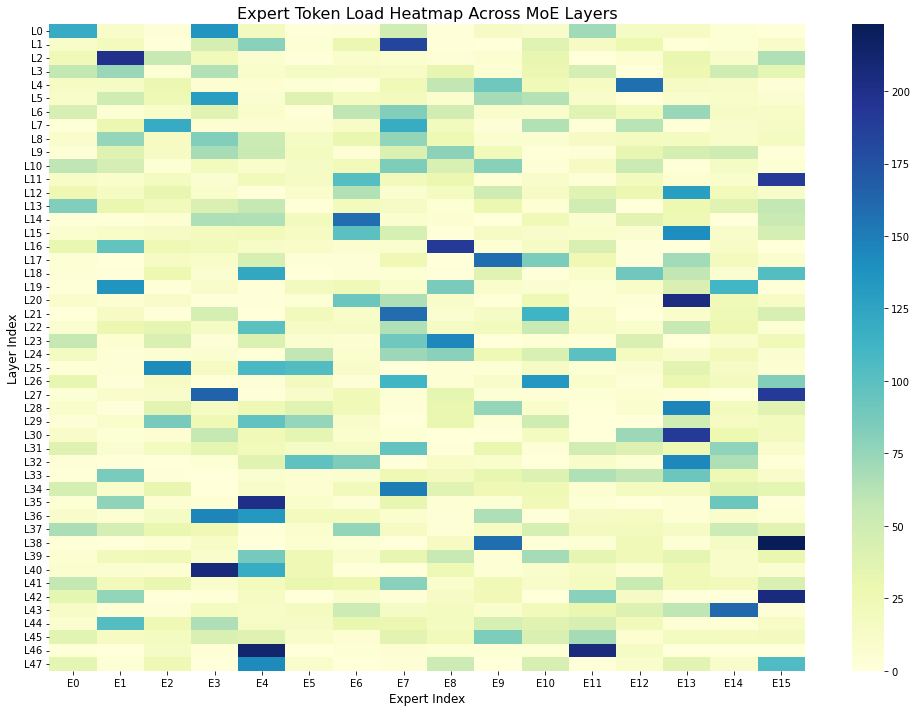

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy array for plotting
load_matrix = all_loads

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(load_matrix, cmap="YlGnBu", annot=False, cbar=True, xticklabels=[f"E{i}" for i in range(num_experts)], yticklabels=[f"L{i}" for i in range(num_layers)])

plt.title("Expert Token Load Heatmap Across MoE Layers", fontsize=16)
plt.xlabel("Expert Index", fontsize=12)
plt.ylabel("Layer Index", fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
kept_experts = []
pruned_experts = []
def rank_and_select_experts(load, importance, keep_ratio=0.5, alpha=0.5):
    load = np.array(load)
    importance = np.array(importance)

    # Normalize
    norm_load = (load - load.min()) / (load.max() - load.min() + 1e-6)
    norm_importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-6)

    # Weighted score
    scores = alpha * norm_load + (1 - alpha) * norm_importance
    num_keep = int(len(scores) * keep_ratio)
    keep_indices = np.argsort(scores)[-num_keep:]
    
    prune_indices = np.setdiff1d(np.arange(len(scores)), keep_indices)
    
    return keep_indices.tolist(), prune_indices.tolist()


for layer in range(num_layers):
    keep_indices, prune_indices = rank_and_select_experts(all_loads[layer], all_importance[layer])
    print(f"Layer {layer} :")
    print(f"Kept experts: {keep_indices}")
    print(f"Prune experts: {prune_indices}")
    kept_experts.append(keep_indices)
    pruned_experts.append(prune_indices)


Layer 0 :
Kept experts: [2, 13, 15, 4, 11, 7, 0, 3]
Prune experts: [1, 5, 6, 8, 9, 10, 12, 14]
Layer 1 :
Kept experts: [0, 1, 12, 6, 3, 4, 10, 7]
Prune experts: [2, 5, 8, 9, 11, 13, 14, 15]
Layer 2 :
Kept experts: [7, 15, 6, 2, 4, 13, 9, 1]
Prune experts: [0, 3, 5, 8, 10, 11, 12, 14]
Layer 3 :
Kept experts: [9, 11, 4, 14, 3, 0, 15, 1]
Prune experts: [2, 5, 6, 7, 8, 10, 12, 13]
Layer 4 :
Kept experts: [2, 8, 7, 10, 9, 11, 1, 12]
Prune experts: [0, 3, 4, 5, 6, 13, 14, 15]
Layer 5 :
Kept experts: [2, 15, 5, 1, 9, 10, 14, 3]
Prune experts: [0, 4, 6, 7, 8, 11, 12, 13]
Layer 6 :
Kept experts: [2, 0, 11, 3, 8, 13, 7, 6]
Prune experts: [1, 4, 5, 9, 10, 12, 14, 15]
Layer 7 :
Kept experts: [3, 8, 1, 14, 12, 10, 2, 7]
Prune experts: [0, 4, 5, 6, 9, 11, 13, 15]
Layer 8 :
Kept experts: [12, 6, 4, 10, 8, 7, 1, 3]
Prune experts: [0, 2, 5, 9, 11, 13, 14, 15]
Layer 9 :
Kept experts: [7, 0, 3, 14, 4, 8, 13, 12]
Prune experts: [1, 2, 5, 6, 9, 10, 11, 15]
Layer 10 :
Kept experts: [11, 1, 0, 9, 12, 3, 7, 8

In [9]:
# MORNING CODE

import torch
import torch.nn as nn
import torch.nn.functional as F

class PrunedLlama4TextMoe(nn.Module):
    def __init__(self, original_moe_layer, kept_indices):
        super().__init__()
        self.shared_expert = original_moe_layer.shared_expert
        self.act_fn       = original_moe_layer.experts.act_fn

        # Keep the full router, but remember which experts to mute
        self.router       = original_moe_layer.router
        self.num_experts  = self.router.out_features

        # Build a boolean mask: True for kept, False for pruned
        mask = torch.zeros(self.num_experts, dtype=torch.bool, 
                           device=self.router.weight.device)
        mask[kept_indices] = True
        self.register_buffer('kept_mask', mask)

    def forward(self, x):
        # x: [B, S, H]
        B, S, H = x.shape
        x_flat = x.view(-1, H)                 # [B*S, H]

        # 1) compute full logits: [B*S, E]
        logits_full = self.router(x_flat)

        # 2) mask out the pruned experts by setting their logits to -inf
        #    so their softmax probability becomes zero:
        masked_logits = logits_full.masked_fill(~self.kept_mask, float('-inf'))

        # 3) softmax over all E experts (pruned ones get zero prob)
        dispatch_probs = F.softmax(masked_logits, dim=-1)  # [B*S, E]

        # 4) run the shared expert once
        expert_out = self.shared_expert(x_flat)            # [B*S, H]
        expanded   = expert_out.unsqueeze(1)               # [B*S, 1, H]
        expanded   = expanded.expand(-1, self.num_experts, -1)  # [B*S, E, H]

        # 5) weight & sum across the expert dimension
        out_flat = (dispatch_probs.unsqueeze(-1) * expanded).sum(dim=1)  # [B*S, H]
        out      = out_flat.view(B, S, H)

        # return the final MoE output plus the original-shaped logits
        return out, logits_full


In [10]:
for i, layer in enumerate(model.language_model.model.layers):
    kept = kept_experts[i]  # From your pruning strategy
    orig_moe = layer.feed_forward
    layer.feed_forward = PrunedLlama4TextMoe(orig_moe, kept)
    if i == 23:
        break

In [11]:
subset = ["问：你今天心情怎么样", "问：你平时喜欢做什么运动", "问：你最喜欢的中国菜是什么?", "问：你通常几点起床", "问：你今天工作／学习的主要任务是什么？", "问：你喜欢听什么类型的音乐？", "问：你下一个假期想去哪里旅行？", "问：你有没有养宠物？它叫什么名字？", "问：你最喜欢的电影是哪一部？", "问：你有什么长期目标或者梦想？"]
for example in subset[0:5]:
    input_text = example
    
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": input_text },
            ]
        },
    ]
    inference(messages)

Total time: 3.5565 seconds

Input text:
问：你今天心情怎么样

Generated text:
我只是一个大型语言模型，我没有个人感受或情绪，但我在这里帮助你！你今天过得怎么样？


Total time: 3.0976 seconds

Input text:
问：你平时喜欢做什么运动

Generated text:
我可以做很多运动，比如跑步、跳舞、瑜伽等等。你喜欢做什么运动呢？


Total time: 6.9922 seconds

Input text:
问：你最喜欢的中国菜是什么?

Generated text:
I'm just a large language model, I don't have opinions or preferences.不过我可以提供一些中国菜的介绍：

* 饺子（tiě jiǎo）
* 包子（bāo zi）
* 馄子（chu


Total time: 3.3683 seconds

Input text:
问：你通常几点起床

Generated text:
我是一个大型语言模型，我没有个人经历或作息。我在这里帮助回答問題，尽我所能！


Total time: 3.6444 seconds

Input text:
问：你今天工作／学习的主要任务是什么？

Generated text:
我只是一个语言模型，我没有个人任务或目标。不过我可以帮助你找到答案，或与你聊天。你怎么了？




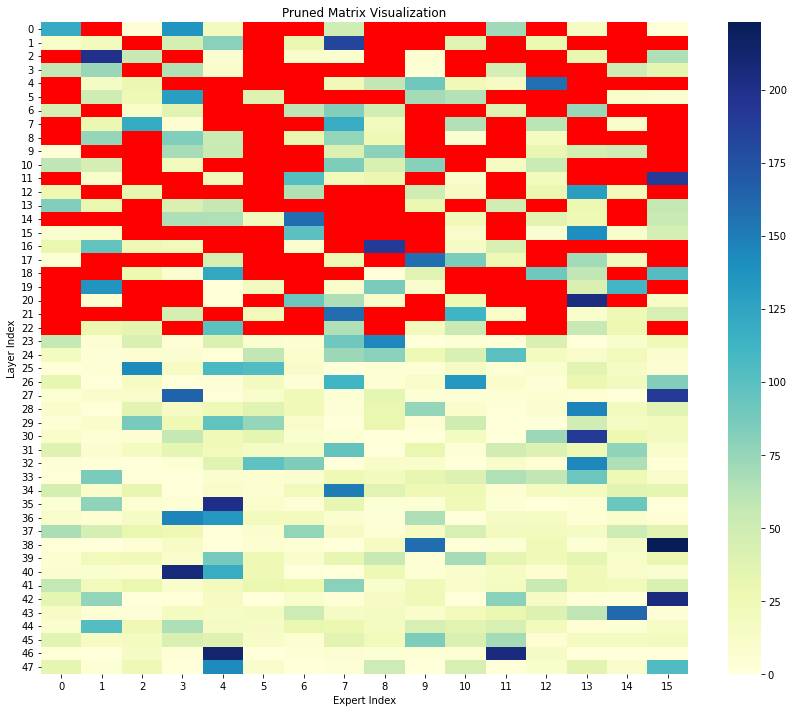

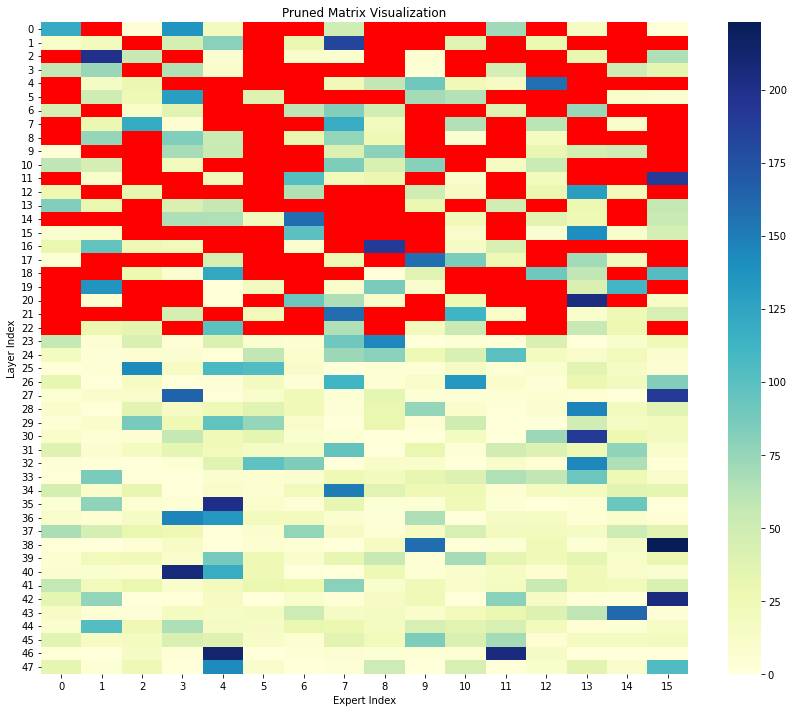

In [12]:
from postprocess import plot_pruned_matrix
plot_pruned_matrix(load_matrix, pruned_experts, num_experts=16, prune_up_to_layer=23, cmap="YlGnBu", figsize=(12, 10), title="Pruned Matrix Visualization")

In [13]:
# print(model.language_model.model.layers[0])

In [14]:
# layer = model.language_model.model.layers[0]
# print(layer.feed_forward)

In [15]:
# print(layer.feed_forward.__class__)

In [16]:
# ###OLD VERSION
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class PrunedLlama4TextMoe(nn.Module):
#     def __init__(self, original_moe_layer, kept_indices):
#         super().__init__()
#         shared = original_moe_layer.shared_expert
#         self.hidden_size = shared.down_proj.out_features
#         self.intermediate_size = shared.up_proj.out_features
#         self.num_experts = len(kept_indices)
#         self.kept_indices = kept_indices

#         # Router is still linear, but we slice output to only kept experts
#         self.router = original_moe_layer.router

#         # Reference the shared expert module (assumes shared across experts)
#         self.shared_expert = original_moe_layer.shared_expert

#         # Store act_fn used inside Llama4TextExperts
#         self.act_fn = original_moe_layer.experts.act_fn

#     def forward(self, x):
#         # x: [batch, seq_len, hidden_size]
#         B, S, H = x.shape
#         x_flat = x.view(-1, H)  # [B*S, H]

#         # Compute router logits and select only kept experts
#         logits = self.router(x_flat)  # [B*S, original_num_experts]
#         logits_subset = logits[:, self.kept_indices]  # [B*S, num_kept_experts]

#         # Softmax over selected experts
#         dispatch_probs = F.softmax(logits_subset, dim=-1)  # [B*S, num_kept_experts]

#         # Dispatch inputs to experts using weighted sum of shared expert output
#         expert_outputs = []
#         for i, expert_idx in enumerate(self.kept_indices):
#             expert_output = self.shared_expert(x_flat)  # [B*S, H]
#             expert_outputs.append(expert_output.unsqueeze(1))

#         stacked_outputs = torch.cat(expert_outputs, dim=1)  # [B*S, num_kept_experts, H]
#         out = torch.sum(stacked_outputs * dispatch_probs.unsqueeze(-1), dim=1)  # [B*S, H]

#         return out.view(B, S, H), logits_subset


In [17]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class PrunedLlama4TextMoe(nn.Module):
#     def __init__(self, original_moe_layer, kept_indices):
#         super().__init__()
#         shared = original_moe_layer.shared_expert
#         self.hidden_size = shared.down_proj.out_features
#         self.intermediate_size = shared.up_proj.out_features
#         self.num_experts = len(kept_indices)
#         self.kept_indices = kept_indices

#         # Construct a new router to only output logits for kept experts
#         self.device = original_moe_layer.router.weight.device
#         self.dtype = original_moe_layer.router.weight.dtype
#         in_dim = original_moe_layer.router.in_features

#         self.router = nn.Linear(in_dim, len(kept_indices), bias=False).to(device=self.device, dtype=self.dtype)
#         with torch.no_grad():
#             self.router.weight.copy_(original_moe_layer.router.weight[kept_indices].to(device=self.device, dtype=self.dtype))

#         self.shared_expert = original_moe_layer.shared_expert.to(device=self.device, dtype=self.dtype)
#         self.act_fn = original_moe_layer.experts.act_fn.to(device=self.device)

#     def forward(self, x):
#         # x: [batch, seq_len, hidden_size]
#         x = x.to(device=self.device, dtype=self.dtype)
#         B, S, H = x.shape
#         x_flat = x.view(-1, H)  # [B*S, H]

#         # Compute router logits (only for kept experts)
#         logits = self.router(x_flat).to(device=self.device)  # [B*S, num_kept_experts]
#         logits_subset = logits[:, self.kept_indices]  # [B*S, num_kept_experts]
#         dispatch_probs = F.softmax(logits_subset, dim=-1)  # [B*S, num_kept_experts]

#         # Call the shared expert once
#         expert_output = self.shared_expert(x_flat)  # [B*S, H]

#         # Broadcast and weight expert output across kept expert dimension
#         expert_output = expert_output.unsqueeze(1).expand(-1, self.num_experts, -1)
#         out = torch.sum(dispatch_probs.unsqueeze(-1) * expert_output, dim=1)  # [B*S, H]

#         return out.view(B, S, H), logits

In [18]:
# # import copy
# # pruned_model = copy.deepcopy(model)
# for i, layer in enumerate(model.language_model.model.layers):
#     kept = kept_experts[i]  # From your pruning strategy
#     orig_moe = layer.feed_forward
#     layer.feed_forward = PrunedLlama4TextMoe(orig_moe, kept)

In [19]:
# print(layer.feed_forward.experts._modules)

In [20]:
# import requests

# url = "https://datasets-server.huggingface.co/rows"
# params = {
#     "dataset": "Muennighoff/mbpp",
#     "config": "full",
#     "split": "test",
#     "offset": 0,
#     "length": 100
# }

# response = requests.get(url, params=params)

# # Print the response or parse JSON
# print(response.json())

In [21]:
# import requests

# # Base API URL
# base_url = "https://datasets-server.huggingface.co/rows"
# dataset = "Muennighoff/mbpp"
# config = "full"
# length = 100  # Number of rows per page; increase or loop if needed

# # Function to fetch split data
# def fetch_split(split, offset=0, length=100):
#     params = {
#         "dataset": dataset,
#         "config": config,
#         "split": split,
#         "offset": offset,
#         "length": length
#     }
#     response = requests.get(base_url, params=params)
#     if response.status_code == 200:
#         data = response.json()
#         return [row["row"] for row in data["rows"]]
#     else:
#         print(f"Error fetching {split} split:", response.status_code)
#         return []

# # Fetch each split
# train_data = fetch_split("train")
# validation_data = fetch_split("validation")
# test_data = fetch_split("test")

# # Preview a few entries
# print("Train Example:", train_data[0] if train_data else "None")
# print()
# print("Validation Example:", validation_data[0] if validation_data else "None")
# print()
# print("Test Example:", test_data[0] if test_data else "None")


In [22]:
# subset = test_data[:10]
# import time
# for example in subset:
#     input_text = example["text"]
    
#     messages = [
#         {
#             "role": "user",
#             "content": [
#                 {"type": "text", "text": input_text },
#             ]
#         },
#     ]
#     inference(messages)

In [23]:
# print(f"Number of tokens: {len(tokenized.input_ids[0])}")

# for idx, probs in enumerate(router_probs[0:1]):
#     print(f"Layer {idx} router probabilities:")
#     print(f"Shape: {probs.shape}")
#     print(f"Top-3 values per token: {torch.topk(probs, 3, dim=-1).values}")
#     print(f"Top-3 indices per token: {torch.topk(probs, 3, dim=-1).indices}")

In [24]:
# """问：你今天心情怎么样？
# 答：我今天心情很好，准备迎接新的一天。

# 问：你平时喜欢做什么运动？
# 答：我平时喜欢跑步和打篮球。

# 问：你最喜欢的中国菜是什么？
# 答：我最喜欢吃麻婆豆腐，因为它又辣又香。

# 问：你通常几点起床？
# 答：我通常早上七点起床。

# 问：你今天工作／学习的主要任务是什么？
# 答：我今天要完成一个重要的项目演示。

# 问：你喜欢听什么类型的音乐？
# 答：我喜欢听流行音乐和一些轻柔的民谣。

# 问：你下一个假期想去哪里旅行？
# 答：我想去云南看风景和品尝当地美食。

# 问：你有没有养宠物？它叫什么名字？
# 答：我有一只猫，名字叫“小灰”。

# 问：你最喜欢的电影是哪一部？
# 答：我最喜欢《肖申克的救赎》，因为故事很感人。

# 问：你有什么长期目标或者梦想？
# 答：我希望能够环游世界，体验不同的文化。"""

In [25]:
# 问：你今天心情怎么样？
# 答：我今天心情很好，准备迎接新的一天。
# Q: How are you feeling today?
# A: I’m feeling great today, ready to embrace a new day.

# 问：你平时喜欢做什么运动？
# 答：我平时喜欢跑步和打篮球。
# Q: What sports do you like to do normally?
# A: I normally like running and playing basketball.

# 问：你最喜欢的中国菜是什么？
# 答：我最喜欢吃麻婆豆腐，因为它又辣又香。
# Q: What is your favorite Chinese dish?
# A: My favorite is Mapo Tofu, because it’s spicy and flavorful.

# 问：你通常几点起床？
# 答：我通常早上七点起床。
# Q: What time do you usually wake up?
# A: I usually wake up at 7 AM.

# 问：你今天工作／学习的主要任务是什么？
# 答：我今天要完成一个重要的项目演示。
# Q: What is your main work/study task today?
# A: Today I need to finish an important project presentation.

# 问：你喜欢听什么类型的音乐？
# 答：我喜欢听流行音乐和一些轻柔的民谣。
# Q: What type of music do you like to listen to?
# A: I like pop music and some soft folk.

# 问：你下一个假期想去哪里旅行？
# 答：我想去云南看风景和品尝当地美食。
# Q: Where do you want to travel on your next holiday?
# A: I want to go to Yunnan to see the scenery and taste local food.

# 问：你有没有养宠物？它叫什么名字？
# 答：我有一只猫，名字叫“小灰”。
# Q: Do you have a pet? What’s its name?
# A: I have a cat named “Xiao Hui.”

# 问：你最喜欢的电影是哪一部？
# 答：我最喜欢《肖申克的救赎》，因为故事很感人。
# Q: What is your favorite movie?
# A: My favorite is “The Shawshank Redemption” because the story is very touching.

# 问：你有什么长期目标或者梦想？
# 答：我希望能够环游世界，体验不同的文化。
# Q: What long‑term goals or dreams do you have?
# A: I hope to travel around the world and experience different cultures.

In [26]:
# """
# इनपुट: आप आज कैसा महसूस कर रहे हैं?
# आउटपुट: मैं आज बहुत अच्छा महसूस कर रहा हूँ, नए दिन का स्वागत करने को तैयार हूँ।

# इनपुट: आप आम तौर पर कौन सा खेल खेलना पसंद करते हैं?
# आउटपुट: मुझे आम तौर पर दौड़ना और बास्केटबॉल खेलना पसंद है।

# इनपुट: आपका पसंदीदा चीनी व्यंजन क्या है?
# आउटपुट: मेरा पसंदीदा व्यंजन मापो टोफू है, क्योंकि यह तीखा और सुगंधित होता है।

# इनपुट: आप आम तौर पर कितने बजे उठते हैं?
# आउटपुट: मैं आम तौर पर सुबह सात बजे उठता हूँ।

# इनपुट: आज आपके काम/अध्ययन का मुख्य कार्य क्या है?
# आउटपुट: आज मुझे एक महत्वपूर्ण परियोजना प्रस्तुति पूरी करनी है।

# इनपुट: आप किस तरह का संगीत सुनना पसंद करते हैं?
# आउटपुट: मुझे पॉप संगीत और हल्की लोक‑गाने सुनना पसंद है।

# इनपुट: आप अपनी अगली छुट्टी में कहाँ यात्रा करना चाहेंगे?
# आउटपुट: मैं युन्नान जाना चाहूँगा, वहाँ का नजारा देखने तथा स्थानीय व्यंजन चखने के लिए।

# इनपुट: क्या आपके पास कोई पालतू है? उसका नाम क्या है?
# आउटपुट: मेरे पास एक बिल्ली है, नाम “छोटू” है।

# इनपुट: आपकी पसंदीदा फिल्म कौन सी है?
# आउटपुट: मेरी पसंदीदा फिल्म “द शॉशैंक रिडेम्प्शन” है, क्योंकि इसकी कहानी बहुत मार्मिक है।

# इनपुट: आपके दीर्घकालिक लक्ष्य या सपने क्या हैं?
# आउटपुट: मैं दुनिया भर की यात्रा करना और विभिन्न संस्कृतियों का अनुभव करना चाहता हूँ।
# #
# """